# News Aggregator using Topic Modeling

![](https://images.unsplash.com/photo-1504711434969-e33886168f5c?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1500&q=80)

This dataset contains headlines, URLs, and categories for 422,937 news stories collected by a web aggregator between March 10th, 2014 and August 10th, 2014.

News categories included in this dataset include business; science and technology; entertainment; and health. Different news articles that refer to the same news item (e.g., several articles about recently released employment statistics) are also categorized together.

Content
The columns included in this dataset are:

- ID : the numeric ID of the article
- TITLE : the headline of the article
- URL : the URL of the article
- PUBLISHER : the publisher of the article
- CATEGORY : the category of the news item; one of: 
        -- b : business 
        -- t : science and technology 
        -- e : entertainment 
        -- m : health
- STORY : alphanumeric ID of the news story that the article discusses
- HOSTNAME : hostname where the article was posted
- TIMESTAMP : approximate timestamp of the article's publication, given in Unix time (seconds since midnight on Jan 1, 1970)

➡️ Can we predict the category (business, entertainment, etc.) of a news article given only its headline?


👉 Source: https://www.kaggle.com/uciml/news-aggregator-dataset/data

First of all, we have to set our Spark environement in Google Colaboratory for the part about Classification.

In [ ]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-2.3.2/spark-2.3.2-bin-hadoop2.7.tgz

# unzip the spark file to the current folder
!tar xf spark-2.3.2-bin-hadoop2.7.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.2-bin-hadoop2.7"

# install findspark using pip
!pip install -q findspark

In [ ]:
!update-alternatives --config java

In [ ]:
!java -version

In [ ]:
!pip install pyLDAvis
!pip install -U gensim

In [ ]:
!python -m spacy download en_core_web_md
!python -m spacy link en_core_web_md en_core_web_md

In [ ]:
import numpy as np
import pandas as pd
import os
import tqdm

import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
from sklearn.metrics import classification_report
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns


from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.models import LsiModel
from pprint import pprint
from gensim.models import LdaModel, LdaMulticore, LsiModel, HdpModel
from gensim.matutils import Sparse2Corpus
from gensim.utils import ClippedCorpus
import pyLDAvis
import pyLDAvis.gensim

import findspark
findspark.init("/content/spark-2.3.2-bin-hadoop2.7")
from pyspark.rdd import ignore_unicode_prefix
from pyspark import SparkContext, SparkConf
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import concat_ws, col, regexp_replace, trim, lower
import pyspark.sql.types as T
from pyspark.ml import Pipeline 
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, Word2Vec, StringIndexer, Tokenizer, RegexTokenizer, StopWordsRemover, VectorAssembler
from pyspark.sql.functions import col, udf, regexp_replace, isnull
from pyspark.sql.types import StringType, IntegerType, ArrayType
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.stat import Correlation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

<h1> Load the data

In [ ]:
#PATH = os.path.join('content', 'uci-news-aggregator.csv')
df = pd.read_csv('/content/uci-news-aggregator.csv')

<h1> Data Preparation

In [ ]:
df.head(2)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207


In [ ]:
df.isna().sum()

ID           0
TITLE        0
URL          0
PUBLISHER    2
CATEGORY     0
STORY        0
HOSTNAME     0
TIMESTAMP    0
dtype: int64

- As there are only two missing values, we drop them.

In [ ]:
df = df.dropna()

In [ ]:
df.shape

(422417, 8)

In [ ]:
# Identify the different values of news article category
df.CATEGORY.unique()

array(['b', 't', 'e', 'm'], dtype=object)

- CATEGORY : the category of the news item; one of: 
        -- b : business 
        -- t : science and technology 
        -- e : entertainment 
        -- m : health

### Convert date

In [ ]:
#df_sample = df.sample(n=10000, random_state=1)
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], unit='ms')

<h1> EDA

### Check the ratio of each category in the dataset

In [ ]:
ratio_cat = df.CATEGORY.value_counts(normalize=True,
                         sort=True,
                         ascending=False)*100

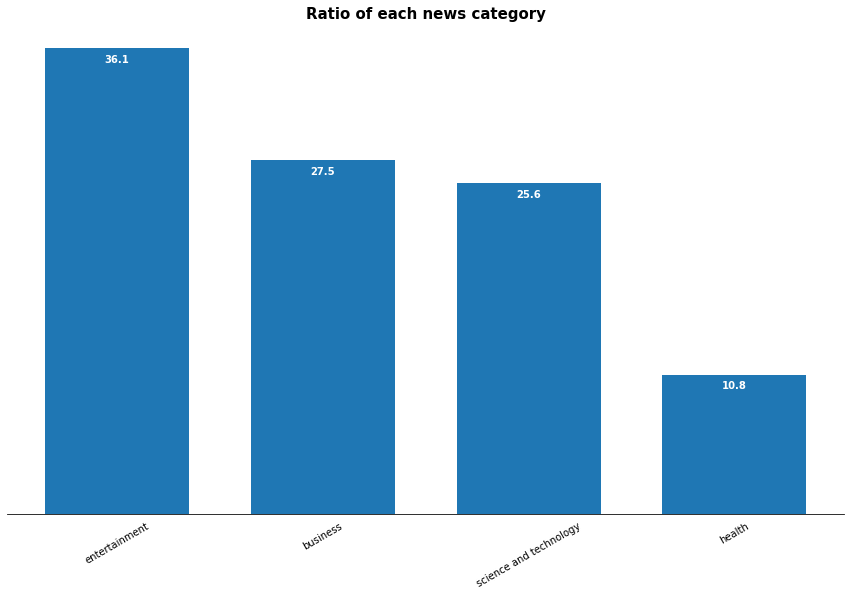

In [ ]:
plt.figure(figsize=(15, 9))

plt.bar(x=pd.Series(ratio_cat.values, index=pd.Index(['entertainment', 'business', 'science and technology', 'health'])).index, height=ratio_cat, width=.7)

sns.despine(left=True)
plt.xticks(rotation=30)
plt.yticks([])

for idx, value in enumerate(ratio_cat):
    plt.text(x=idx, y=ratio_cat[idx] - .5, s=round(ratio_cat[idx], 1),
    ha='center', va='top', color='white', fontweight='bold')
    
plt.tick_params(bottom=False)
    
plt.title('Ratio of each news category', fontsize=15, fontweight='bold')

plt.show()

- Categories are quite balanced.

## News Timeline

In [ ]:
start, end = df['TIMESTAMP'].min(), df['TIMESTAMP'].max()
print(f'News timeline starts at: {start} and ends at: {end}.')
print(f'News timeline has been collected for a range time of: {end - start}.')

News timeline starts at: 2014-03-10 16:52:50.698000 and ends at: 2014-08-28 12:33:11.565000.
News timeline has been collected for a range time of: 170 days 19:40:20.867000.


### Check the ratio of each publisher in the dataset

In [ ]:
ratio_pub = df.PUBLISHER.value_counts(normalize=False,
                         sort=True,
                         ascending=False)[:5]
ratio_pub

Reuters             3902
Huffington Post     2455
Businessweek        2395
Contactmusic.com    2334
Daily Mail          2254
Name: PUBLISHER, dtype: int64

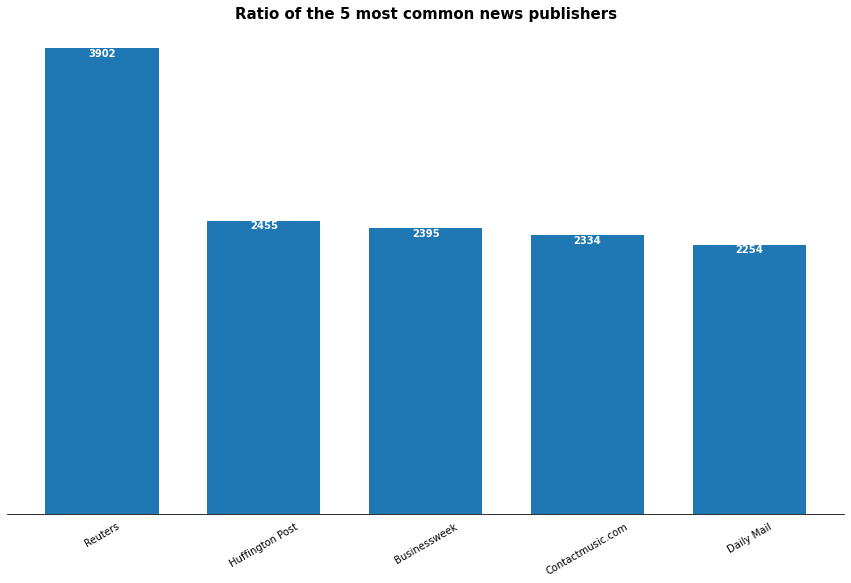

In [ ]:
plt.figure(figsize=(15, 9))

plt.bar(x=ratio_pub.index.tolist(), height=ratio_pub, width=.7)

sns.despine(left=True)
plt.xticks(rotation=30)
plt.yticks([])

for idx, value in enumerate(ratio_pub):
    plt.text(x=idx, y=ratio_pub[idx] - .5, s=round(ratio_pub[idx], 1),
    ha='center', va='top', color='white', fontweight='bold')
    
plt.tick_params(bottom=False)
    
plt.title('Ratio of the 5 most common news publishers', fontsize=15, fontweight='bold')

plt.show()

<h1> Preprocessing of our news titles

In [ ]:
nlp = spacy.load('en_core_web_md')

In [ ]:
def text_process_spacy(mess):
    tokens = [token.lemma_.lower() for token in nlp(mess) if token.is_alpha and not token.is_punct and not token.is_stop]
    return tokens

In [ ]:
%%time
df['TITLE_PROCESSED'] = df['TITLE'].apply(text_process_spacy)

CPU times: user 1h 2min 2s, sys: 3.97 s, total: 1h 2min 6s
Wall time: 1h 2min 6s


In [ ]:
#df.to_csv(os.path.join('..', 'data', 'processed_df.csv'))

In [ ]:
df.head(2)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,TITLE_PROCESSED
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,2014-03-10 16:52:50.698,"[fed, official, say, weak, datum, cause, weath..."
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,2014-03-10 16:52:51.207,"[fed, charles, plosser, see, high, bar, change..."


<h1> Build our gensim BOW

- Create a corpus

In [ ]:
corpus = df['TITLE_PROCESSED']

- Compute the dictionary: this is a dictionary mapping words and their corresponding numbers for later visualisation

In [ ]:
id2word = Dictionary(corpus)

- Create a gensim BOW of news article headlines 

In [ ]:
bow = [id2word.doc2bow(line) for line in corpus]

## Applying Latent Dirichlet Allocation (LDA) Model

In [ ]:
%%time
lda_multi_model = LdaMulticore(bow,
                         num_topics=4,
                         id2word=id2word,
                         passes=10,
                         workers=2)

CPU times: user 6min 7s, sys: 15.3 s, total: 6min 22s
Wall time: 6min 17s


In [ ]:
pprint(lda_multi_model.print_topics())

[(0,
  '0.010*"facebook" + 0.009*"study" + 0.008*"new" + 0.007*"say" + '
  '0.006*"american" + 0.005*"user" + 0.005*"ceo" + 0.005*"help" + '
  '0.005*"charge" + 0.005*"xbox"'),
 (1,
  '0.012*"video" + 0.012*"new" + 0.009*"star" + 0.009*"watch" + 0.007*"review" '
  '+ 0.005*"bieber" + 0.005*"movie" + 0.005*"bachelorette" + 0.005*"justin" + '
  '0.005*"live"'),
 (2,
  '0.019*"ebola" + 0.016*"google" + 0.010*"west" + 0.010*"ice" + '
  '0.010*"challenge" + 0.008*"kardashian" + 0.008*"bucket" + 0.008*"amazon" + '
  '0.007*"case" + 0.007*"kim"'),
 (3,
  '0.016*"apple" + 0.012*"galaxy" + 0.010*"stock" + 0.009*"samsung" + '
  '0.009*"microsoft" + 0.008*"sale" + 0.008*"price" + 0.008*"buy" + '
  '0.007*"china" + 0.007*"high"')]


At first glance, our model seems to be coherent with the existing categories:
- The first topic obviously corresponds to Business
- The second one to Entertainment
- The third one to Health
- The fourth one to Science and Technology

However, we can observe a mix between the two last categories. Is it because the Health category is smaller than the others or because there are less than 4 categories in reality?

In [ ]:
#%%time
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=lda_multi_model, 
                              corpus=bow, 
                              dictionary=id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.344830  0.093456       1        1  28.972223
3     -0.200925  0.281710       2        1  26.987074
0     -0.019638 -0.212603       3        1  22.321947
2     -0.124266 -0.162563       4        1  21.718755, topic_info=          Term          Freq         Total Category  logprob  loglift
12861    ebola  11246.000000  11246.000000  Default  30.0000  30.0000
1640     apple  11563.000000  11563.000000  Default  29.0000  29.0000
1695    google   9277.000000   9277.000000  Default  28.0000  28.0000
1185     video   9720.000000   9720.000000  Default  27.0000  27.0000
2032    galaxy   8823.000000   8823.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
189    million   2919.718960   5227.614026   Topic4  -5.3173   0.9445
111        new   4186.983850  23030.694051   Topic4  -4.9568  -0.1779
219     report   3117.247553   9134.393314   Topic4  -5.2518   0.4519
93        test   2353.325740   3719.365593   Topic4  -5.5330   1.0693
4          say   2333.788154  10225.656685   Topic4  -5.5413   0.0496

[189 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
1308       4  0.999418    africa
664        3  0.999790  airlines
43661      1  0.002198       als
43661      2  0.000733       als
43661      3  0.002930       als
...      ...       ...       ...
1324       3  0.999679   windows
809        1  0.235852     world
809        4  0.763978     world
1305       3  0.999876      xbox
8745       1  0.999745         z

[206 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])

![lda_multi_model-4_topics.png](attachment:NLP/Topic_Modeling_Text_Classification_PySpark/vizualisations/lda_multi_model-4_topics.png)

We can see that the first bubbles that represent repectively Entertainement and Business are explicitly separated. Whilst the two last ones overlapped at some level. This suggests that they share topics and thus have to be one sigle topic.

In [ ]:
%%time
lda1 = LdaModel(corpus=bow, 
                num_topics=3, 
                id2word=id2word, 
                random_state=42)

CPU times: user 1min 19s, sys: 81.7 ms, total: 1min 19s
Wall time: 1min 19s


In [ ]:
pprint(lda1.print_topics())

[(0,
  '0.030*"ebola" + 0.008*"stock" + 0.008*"health" + 0.007*"say" + '
  '0.007*"outbreak" + 0.007*"report" + 0.006*"case" + 0.006*"virus" + '
  '0.006*"high" + 0.006*"china"'),
 (1,
  '0.016*"apple" + 0.012*"galaxy" + 0.011*"new" + 0.011*"challenge" + '
  '0.010*"microsoft" + 0.008*"price" + 0.007*"samsung" + 0.007*"google" + '
  '0.007*"buy" + 0.006*"july"'),
 (2,
  '0.011*"new" + 0.010*"video" + 0.008*"watch" + 0.007*"star" + 0.006*"ice" + '
  '0.006*"guardian" + 0.006*"bucket" + 0.005*"review" + 0.005*"mtv" + '
  '0.005*"bachelorette"')]


In [ ]:
topic_mapping = {
    0: "Health",
    1: "Business & Technology",
    2: "Entertainment"
}

new_headlines = [
    "Beyonce won a music award",
    "Samsung releases new product - stock rises",
    "New cow disease outbreaks with multiple symptoms endagers humans"
]

def rank_headline(headline):
    bow_vector = id2word.doc2bow(text_process_spacy(headline))
    lda_vector = lda1[bow_vector]
    top_topic = topic_mapping[max(lda_vector, key=lambda item: item[1])[0]]
    distribution = {topic_mapping[topic_no]: proportion for topic_no, proportion in lda_vector}
    return top_topic, distribution

for headline in new_headlines:
    top_topic, distribution = rank_headline(headline)
    print(f"{headline}: {top_topic} \n Topic Mix: {distribution}\n")

Beyonce won a music award: Entertainment 
 Topic Mix: {'Health': 0.06776138, 'Business & Technology': 0.067209005, 'Entertainment': 0.86502963}

Samsung releases new product - stock rises: Business & Technology 
 Topic Mix: {'Health': 0.3272729, 'Business & Technology': 0.62156874, 'Entertainment': 0.051158383}

New cow disease outbreaks with multiple symptoms endagers humans: Health 
 Topic Mix: {'Health': 0.7260087, 'Business & Technology': 0.22996916, 'Entertainment': 0.044022147}



## Applying Latent Dirichlet Allocation (LDA) Model with Tf-Idf

In [ ]:
%%time
tfidf_model = TfidfModel(bow)

tf_idf_gensim = tfidf_model[bow]

lda_tfidf = LdaModel(corpus=tf_idf_gensim, 
                num_topics=3, 
                id2word=id2word, 
                passes=10)

# Print the main topics
pprint(lda_tfidf.print_topics())

[(0,
  '0.007*"ice" + 0.006*"stock" + 0.005*"health" + 0.005*"price" + '
  '0.005*"challenge" + 0.005*"job" + 0.005*"july" + 0.004*"report" + '
  '0.004*"sale" + 0.004*"china"'),
 (1,
  '0.027*"ebola" + 0.007*"guardian" + 0.006*"case" + 0.006*"microsoft" + '
  '0.005*"virus" + 0.005*"apple" + 0.005*"buy" + 0.005*"burger" + '
  '0.005*"bachelorette" + 0.005*"king"'),
 (2,
  '0.008*"galaxy" + 0.005*"new" + 0.005*"ipad" + 0.005*"video" + '
  '0.004*"iphone" + 0.004*"samsung" + 0.004*"mtv" + 0.004*"vma" + '
  '0.004*"panda" + 0.004*"apple"')]
CPU times: user 13min 36s, sys: 481 ms, total: 13min 37s
Wall time: 13min 36s


Now it's easier to distinguish the different topics by reducing their numbers:
- Health
- Bunsiness, Science and Technology
- Entertainment

Let's evaluate our model:

   - Coherence Score: Higher is better


In [ ]:
# check the coherence of the model
# Improve your preprocessing or adjust num_topics to improve your coherence
from gensim.models.coherencemodel import CoherenceModel


coherencemodel = CoherenceModel(model=lda_tfidf, texts=corpus, dictionary=id2word)
print("coherence for lda with tfidf", coherencemodel.get_coherence())

coherence for lda with tfidf 0.46287866931982197


In [ ]:
# visualize different topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=lda_tfidf, 
                              corpus=tf_idf_gensim, 
                              dictionary=id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.222173  0.217190       1        1  34.851196
0     -0.312933  0.070702       2        1  33.784451
1      0.090759 -0.287892       3        1  31.364352, topic_info=            Term         Freq        Total Category  logprob  loglift
12861      ebola  8671.000000  8671.000000  Default  30.0000  30.0000
2032      galaxy  2743.000000  2743.000000  Default  29.0000  29.0000
4999         ice  2585.000000  2585.000000  Default  28.0000  28.0000
10249   guardian  2284.000000  2284.000000  Default  27.0000  27.0000
1587        case  2049.000000  2049.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1290      review  1143.969021  1609.041811   Topic3  -5.6434   0.8184
10535   outbreak  1256.378775  2462.202921   Topic3  -5.5497   0.4867
111          new  1394.191621  3811.250847   Topic3  -5.4456   0.1539
774          big  1131.077273  1953.489044   Topic3  -5.6547   0.6131
1238   challenge  1176.245029  2832.408293   Topic3  -5.6156   0.2807

[172 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
1308       3  0.998915    africa
664        1  0.998409  airlines
664        2  0.001270  airlines
2526       1  0.999204     album
43661      1  0.176772       als
...      ...       ...       ...
865        3  0.001259      west
216        3  0.999279       win
1324       1  0.998807   windows
1305       3  0.998569      xbox
8745       1  0.999309         z

[219 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

Better!

In [ ]:
%%time
lda_tfidf1 = LdaModel(corpus=tf_idf_gensim,
                     id2word=id2word,
                     num_topics=3,
                     random_state=100,
                     chunksize=100,
                     passes=10,
                     alpha=0.01,
                     eta=0.9)

CPU times: user 30min 18s, sys: 8.27 s, total: 30min 26s
Wall time: 30min 26s


In [ ]:
pprint(lda_tfidf1.print_topics())

[(0,
  '0.020*"ebola" + 0.019*"bucket" + 0.017*"challenge" + 0.017*"ice" + '
  '0.011*"als" + 0.006*"outbreak" + 0.006*"nile" + 0.005*"health" + '
  '0.005*"virus" + 0.005*"west"'),
 (1,
  '0.016*"apple" + 0.015*"ipad" + 0.008*"burger" + 0.008*"tim" + '
  '0.007*"hortons" + 0.007*"iphone" + 0.007*"king" + 0.007*"network" + '
  '0.007*"playstation" + 0.007*"battery"'),
 (2,
  '0.008*"bieber" + 0.008*"chelsea" + 0.007*"justin" + 0.007*"emmys" + '
  '0.007*"vma" + 0.006*"emmy" + 0.006*"mtv" + 0.006*"house" + 0.005*"ivy" + '
  '0.005*"handler"')]


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=lda_tfidf1, 
                              corpus=tf_idf_gensim, 
                              dictionary=id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.091691  0.192801       1        1  33.753783
2     -0.249612 -0.031333       2        1  33.208089
0      0.157921 -0.161468       3        1  33.038128, topic_info=                Term         Freq        Total Category  logprob  loglift
12861          ebola  6716.000000  6716.000000  Default  30.0000  30.0000
10326         bucket  6598.000000  6598.000000  Default  29.0000  29.0000
1640           apple  5563.000000  5563.000000  Default  28.0000  28.0000
4999             ice  5904.000000  5904.000000  Default  27.0000  27.0000
1647            ipad  5072.000000  5072.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
598    investigation  1024.600335  1507.951923   Topic3  -5.8056   0.7211
566              man  1059.026732  1631.875698   Topic3  -5.7725   0.6751
4                say  1014.477110  2289.589066   Topic3  -5.8155   0.2935
219           report   921.691897  2474.731265   Topic3  -5.9114   0.1198
111              new   942.469634  3764.441613   Topic3  -5.8891  -0.2773

[207 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
2103       1  0.993530        aapl
2103       2  0.003379        aapl
2103       3  0.003379        aapl
16         1  0.001958  accelerate
16         2  0.001958  accelerate
...      ...       ...         ...
1305       2  0.002695        xbox
1305       3  0.005391        xbox
36828      1  0.023326        zara
36828      2  0.918254        zara
36828      3  0.058031        zara

[525 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [ ]:
%%time
coherence_model_lda_tfidf1 = CoherenceModel(model=lda_tfidf1,
                                      texts=corpus,
                                      dictionary=id2word,
                                      coherence='c_v')
    
print(coherence_model_lda_tfidf1.get_coherence())

0.5060598911074887
CPU times: user 2.61 s, sys: 1.96 s, total: 4.57 s
Wall time: 4.8 s


- coherence has improved with adding hyperparameters

- Show each topic with its probabilities

In [ ]:
lda_tfidf1.show_topic(0), '\n', lda_tfidf1.show_topic(1), '\n', lda_tfidf1.show_topic(2)

([('ebola', 0.019728769),
  ('bucket', 0.018644141),
  ('challenge', 0.016830867),
  ('ice', 0.016744746),
  ('als', 0.01064725),
  ('outbreak', 0.0058708154),
  ('nile', 0.005597943),
  ('health', 0.0052315407),
  ('virus', 0.0049651116),
  ('west', 0.0048259613)],
 '\n',
 [('apple', 0.015787203),
  ('ipad', 0.0145811625),
  ('burger', 0.008001662),
  ('tim', 0.0075144577),
  ('hortons', 0.007319612),
  ('iphone', 0.0072837314),
  ('king', 0.0071546384),
  ('network', 0.0068196594),
  ('playstation', 0.006762018),
  ('battery', 0.0065343166)],
 '\n',
 [('bieber', 0.008394344),
  ('chelsea', 0.008145087),
  ('justin', 0.0073408443),
  ('emmys', 0.006674103),
  ('vma', 0.0065627745),
  ('emmy', 0.006120867),
  ('mtv', 0.0059534614),
  ('house', 0.0057827155),
  ('ivy', 0.0049785543),
  ('handler', 0.0049369326)])

Let's show top 10 words in all the topics (excluding the probabilities).

In [ ]:
for topic_id in range(lda_tfidf1.num_topics):
    topk = lda_tfidf1.show_topic(topic_id, 10)
    topk_words = [w for w, _ in topk]
    
    print(f"{topic_id}: {' '.join(topk_words)}")


0: ebola bucket challenge ice als outbreak nile health virus west
1: apple ipad burger tim hortons iphone king network playstation battery
2: bieber chelsea justin emmys vma emmy mtv house ivy handler


<h1> Compare LDA topics to our predefined categories

In [ ]:
%%time
# Instantiate the TF-IDF vectorizer
vectorizer = TfidfVectorizer(analyzer=lambda x: x)

# Compute the TF-IDF
tf_idf = vectorizer.fit_transform(df['TITLE_PROCESSED'])

dictionary = Dictionary(df['TITLE_PROCESSED'])
print(dictionary)

# Convert the TF-IDF to the needed input for Gensim
tf_idf_sklearn = Sparse2Corpus(tf_idf, documents_columns=False)

# Compute the LDA
lda_tfidf_sk = LdaModel(corpus=tf_idf_sklearn, 
                id2word=id2word, 
                num_topics=3, 
                passes=10)

# Print the main topics
pprint(lda_tfidf_sk.print_topics())

Dictionary(44066 unique tokens: ['cause', 'datum', 'fed', 'official', 'say']...)
[(0,
  '0.009*"flood" + 0.009*"horowitz" + 0.008*"camden" + 0.007*"snapper" + '
  '0.007*"ecoboost" + 0.006*"gamepur" + 0.005*"impregnate" + 0.005*"dupont" + '
  '0.005*"polarizing" + 0.005*"athena"'),
 (1,
  '0.008*"steiner" + 0.008*"quirky" + 0.005*"flunker" + 0.005*"umar" + '
  '0.005*"fanatic" + 0.005*"meditative" + 0.005*"portlandia" + 0.005*"fortwo" '
  '+ 0.004*"regulator" + 0.004*"disclaimer"'),
 (2,
  '0.023*"dictatorship" + 0.006*"producing" + 0.006*"arrays" + 0.005*"wqow" + '
  '0.005*"whimsical" + 0.005*"frayed" + 0.005*"population" + 0.005*"rfk" + '
  '0.004*"negligent" + 0.004*"liquids"')]
CPU times: user 10min 59s, sys: 671 ms, total: 11min
Wall time: 11min


- Not better!

Are we able to identify clearly the topics? Yes
So, let's create a mapping between our LDA topics and the article category and test them with new titles.

In [ ]:


topic_mapping = {
    0: "Health",
    1: "Business & Technology",
    2: "Entertainment"
}

new_headlines = [
    "Beyonce won a music award",
    "Samsung releases new product - stock rises",
    "New cow disease outbreaks with multiple symptoms endagers humans"
]

def rank_headline(headline):
    bow_vector = id2word.doc2bow(text_process_spacy(headline))
    lda_vector = lda_tfidf1[bow_vector]
    top_topic = topic_mapping[max(lda_vector, key=lambda item: item[1])[0]]
    distribution = {topic_mapping[topic_no]: proportion for topic_no, proportion in lda_vector}
    return top_topic, distribution

for headline in new_headlines:
    top_topic, distribution = rank_headline(headline)
    print(f"{headline}: {top_topic} \n Topic Mix: {distribution}\n")

Beyonce won a music award: Entertainment 
 Topic Mix: {'Entertainment': 0.99503696}

Samsung releases new product - stock rises: Business & Technology 
 Topic Mix: {'Business & Technology': 0.99668276}

New cow disease outbreaks with multiple symptoms endagers humans: Health 
 Topic Mix: {'Health': 0.99711967}



Impressive!

In [ ]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary,
                             num_topics=k,
                             random_state=100,
                             chunksize=100,
                             passes=10,
                             alpha=a,
                             eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, 
                      num_topics=num_topics, 
                      id2word=dictionary,
                      random_state=100,
                      chunksize=100,
                      passes=10,
                      alpha=0.01,
                      eta=0.9)
        
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v


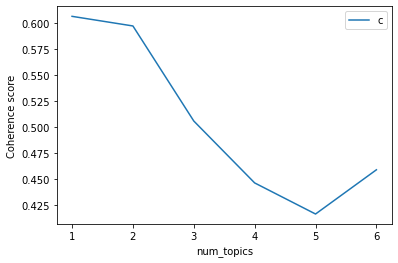

CPU times: user 3h 13min 8s, sys: 2min 36s, total: 3h 15min 44s
Wall time: 3h 15min 44s


([<gensim.models.ldamodel.LdaModel at 0x7f4620014c88>,
 [0.6068768003202933,
  0.5976054005015261,
  0.5060598911074887,
  0.44643423723894604,
  0.4164924023620314,
  0.4590847120898556])

In [ ]:
%%time
evaluate_graph(id2word, tf_idf_gensim, corpus, 7)#bow

Unfortunately, this graph doesn't really help us more because it suggests that we reach the highest coherence score with one topic! It is propably caused by unbalnced class of health compared to the others.

### Let's try to tune our model by finding the best hyperparameters.
>**Since it would take 80 hours to achieve all the iterations, we will do it another time.

In [ ]:
%%time
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 7
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(bow)
corpus_sets = [ClippedCorpus(bow, int(num_of_docs*0.75)), 
               bow]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
    pbar.close()


# Text Classification with PySpark
Applying a simple model of Machine Learning giving the size of the data would have been time costly. Thankfully, we can combine the simplicity of Python with the power of Apache Spark, in order to tame the big data!

## Strategy:

- We're going to process titles both with PySpark which means without lemmatization and a second time with our spaCy function adapted for PySpark but with lemmatization. The objective is to compare results of classification with those two processings.

- Apply Logistic Regression and Naive Bayes algorithms on processed data as bag of words, tfidf and finally with word emebedding. All this, to keep the best combination of processing tool and words representation.











After setting the Spark environement, we have to start a spark session with some configurations in order to avoid Google Colab crashing.

In [ ]:
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.memory", "45g") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "1000M") \
    .config("spark.driver.maxResultSize", "0") \
    .appName("News-Aggregator-Prediction") \
    .getOrCreate()


In [ ]:
news_df = spark.read.load('/content/uci-news-aggregator.csv', 
                          header='true', 
                          treatEmptyValuesAsNulls='true', 
                          inferSchema="true", 
                          format='com.databricks.spark.csv')

In [ ]:
news_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- TITLE: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- PUBLISHER: string (nullable = true)
 |-- CATEGORY: string (nullable = true)
 |-- STORY: string (nullable = true)
 |-- HOSTNAME: string (nullable = true)
 |-- TIMESTAMP: string (nullable = true)



In [ ]:
news_df.dropDuplicates().show()

+----+--------------------+--------------------+--------------------+--------+--------------------+--------------------+-------------+
|  ID|               TITLE|                 URL|           PUBLISHER|CATEGORY|               STORY|            HOSTNAME|    TIMESTAMP|
+----+--------------------+--------------------+--------------------+--------+--------------------+--------------------+-------------+
| 166|Don't Chase Stock...|http://investorpl...|   Investorplace.com|       b|dchKRTV8vDviyCMH_...|   investorplace.com|1394472092116|
| 381|American Airlines...|http://www.dailyb...|        Daily Breeze|       b|dqGernbFbzJ9-vM23...| www.dailybreeze.com|1394479539110|
| 567|Sbarro pizza chai...|http://www.nydail...| New York Daily News|       b|dKtO7lhuRoSQrcML_...| www.nydailynews.com|1394483912844|
| 744|Business news and...|http://www.telegr...|     Telegraph.co.uk|       b|d2OyTeAXDFQpb3M9C...| www.telegraph.co.uk|1394487587361|
|1334|Google Will Relea...|http://www.cruxia...|       

In [ ]:
news_df = news_df.dropDuplicates()

In [ ]:
# print dataset size
print((news_df.count(), len(news_df.columns)))

(422937, 8)


In [ ]:
title_category = news_df.select("TITLE", "CATEGORY")

In [ ]:
title_category = title_category.dropna()

In [ ]:
print((title_category.count(), len(title_category.columns)))

(422421, 2)


In [ ]:
title_category.show()

+--------------------+--------+
|               TITLE|CATEGORY|
+--------------------+--------+
|Don't Chase Stock...|       b|
|American Airlines...|       b|
|Sbarro pizza chai...|       b|
|Business news and...|       b|
|Google Will Relea...|       t|
|Android SDK For W...|       t|
|Apple releases up...|       t|
|Apple Releases iO...|       t|
|Game of Thrones s...|       e|
|Zac Efron open to...|       e|
|'True Detective' ...|       e|
|Watch The Nationa...|       e|
|SXSW Film's First...|       e|
|Maybe ban these i...|       e|
|Why Sheryl Sandbe...|       e|
|The Switchboard: ...|       b|
|Growth strengthen...|       b|
|Virtu IPO Filing:...|       b|
|High-frequency tr...|       b|
|Cosmos: A Spaceti...|       t|
+--------------------+--------+
only showing top 20 rows



Text processing using PySpark

In [ ]:
#----------------Define text preprocessings ------------------
title_category = title_category\
                .withColumn("IS_ALPHA", 
                            regexp_replace(col("TITLE"), 
                                           r"(\d+)", "")
                            )
title_category = title_category\
                .withColumn("LOWERED_NO_PUNCT", 
                            trim(lower(regexp_replace(col("IS_ALPHA"), 
                                                      r'(([^\s\w_]|_)+)', ' '))))

title_category = title_category\
                .withColumn("LOWERED_NO_PUNCT", 
                            trim(lower(regexp_replace(col("LOWERED_NO_PUNCT"), 
                                                      r'(\s+)', ' '))))



In [ ]:
#-----------Encode the Category variable into label using StringIndexer-----------
                         
label_string_idx = StringIndexer(inputCol="CATEGORY", 
                                 outputCol="label")

title_category = label_string_idx.fit(title_category).transform(title_category)

Text processing using spaCy.
Explanation:
- We have to adapt python libraries using PySpark.
- In the case of spaCy, we have to ensure getting, otherwise we get an error saying spaCy not found.
- We have to transform python functions into user-defined function (udf), defining:
    - Using a decorator @ and F for pyspark function ;
    - Type of what the function returns StringType or ArrayType(StringType()) is it is a list of strings (it somehow very similar to Java syntax)

In [ ]:
class SpacyMagic(object):
    """
    Simple Spacy Magic to minimize loading time.
    >>> SpacyMagic.get('en_core_web_md')
    <spacy.en.en_core_web_md ...
    """
    _spacys = {}

    @classmethod
    def get(cls, model):
        if model not in cls._spacys:
            import spacy
            cls._spacys[model] = spacy.load(model)
        return cls._spacys[model]

#@F.udf(T.ArrayType(StringType()))
@F.udf(T.StringType())    
def process_text_pyspark_spacy(sent):
    nlp = SpacyMagic.get('en_core_web_md')
    tokens = [token.lemma_.lower() for token in nlp(sent) if token.is_alpha and not token.is_punct and not token.is_stop]
    return ' '.join(tokens)


In [ ]:
%%time
title_category = title_category.withColumn("TEXT_SPACY", process_text_pyspark_spacy(title_category["TITLE"]))

CPU times: user 8.01 ms, sys: 918 µs, total: 8.93 ms
Wall time: 32.9 ms


Impressive! It took spaCy only 32.9 ms to process the whole column with PySpark, whilst it took it 1h 2min 6s with Pandas DataFrame column.

In [ ]:
title_category = title_category.select("TEXT_SPACY", "CATEGORY", "label")

In [ ]:
title_category.cache()

DataFrame[TEXT_SPACY: string, CATEGORY: string, label: double]

In [ ]:
title_category.show()

+--------------------+--------+
|    LOWERED_NO_PUNCT|CATEGORY|
+--------------------+--------+
|don t chase stock...|       b|
|american airlines...|       b|
|sbarro pizza chai...|       b|
|business news and...|       b|
|google will relea...|       t|
|android sdk for w...|       t|
|apple releases up...|       t|
|apple releases io...|       t|
|game of thrones s...|       e|
|zac efron open to...|       e|
|true detective cr...|       e|
|watch the nationa...|       e|
|sxsw film s first...|       e|
|maybe ban these i...|       e|
|why sheryl sandbe...|       e|
|the switchboard c...|       b|
|growth strengthen...|       b|
|virtu ipo filing ...|       b|
|high frequency tr...|       b|
|cosmos a spacetim...|       t|
+--------------------+--------+
only showing top 20 rows



## Split Data into train/test.

In [ ]:
X_y_train, X_y_test = title_category.randomSplit([0.8, 0.2], seed=60)

## Define diffrent stages of the pipeline data processing

In [ ]:
#----------------Define tokenizer with regextokenizer()------------------
regex_tokenizer = RegexTokenizer(inputCol="LOWERED_NO_PUNCT", #"TEXT_SPACY"
                                 outputCol="TOKENS", # TOKENS_SPACY
                                 pattern="\\W")

#----------------Define stopwords with stopwordsremover()---------------------
extra_stopwords = ['http','amp','rt','t','c','the']
stopwords_remover = StopWordsRemover(inputCol="TOKENS",
                                     outputCol="TOKENS_NO_LEMMA",
                                     stopWords=extra_stopwords)


#----------Define bags of words using countVectorizer()---------------------------
count_vectors = CountVectorizer(inputCol="TOKENS_NO_LEMMA", # "TOKENS_SPACY"
                                outputCol="features",
                                vocabSize=10000,
                                minDF=5)

#-----------Using TF-IDF to vectorise features instead of countVectoriser-----------------
hashingTf = HashingTF(inputCol="TOKENS_NO_LEMMA", # "TOKENS_SPACY"
                      outputCol="raw_features",
                      numFeatures=10000)
 
#Use minDocFreq to remove sparse terms
idf = IDF(inputCol="raw_features",
          outputCol="features",
          minDocFreq=5)

#---------------Define bag of words using Word2Vec---------------------------
word2Vec = Word2Vec(inputCol="TOKENS_NO_LEMMA", # "TOKENS_SPACY" 
                    outputCol="features",
                    vectorSize=1000, 
                    minCount=0)

In [ ]:
#-----------Define classifier structure for logistic Regression--------------
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

#---------Define classifier structure for Naive Bayes----------
nb = NaiveBayes(modelType="multinomial", smoothing=1)

In [ ]:
%%time
pipeline_cv_lr = Pipeline(stages=[regex_tokenizer, 
                     stopwords_remover,
                     count_vectors, 
                     lr])

predictions_cv_lr = pipeline_cv_lr.fit(X_y_train).transform(X_y_test)

CPU times: user 71.8 ms, sys: 30.6 ms, total: 102 ms
Wall time: 3min 59s


In [ ]:
%%time
evaluator_cv_lr = MulticlassClassificationEvaluator(labelCol="label", 
                                                  predictionCol="prediction", 
                                                  metricName="accuracy")

cv_lr_accuracy = evaluator_cv_lr.evaluate(predictions_cv_lr)
print(f"Accuracy of Logistic Regression with no lemmas + cv = {cv_lr_accuracy}")

Accuracy of Logistic Regression with no lemmas + cv = 0.9264742370358118
CPU times: user 2.6 ms, sys: 2.43 ms, total: 5.03 ms
Wall time: 2.13 s


In [ ]:
%%time
pipeline_cv_nb = Pipeline(stages=[regex_tokenizer, 
                     stopwords_remover,
                     count_vectors, 
                     nb])

predictions_cv_nb = pipeline_cv_nb.fit(X_y_train).transform(X_y_test)

CPU times: user 30.4 ms, sys: 6.74 ms, total: 37.1 ms
Wall time: 7.95 s


In [ ]:
%%time
evaluator_cv_nb = MulticlassClassificationEvaluator(labelCol="label", 
                                                  predictionCol="prediction", 
                                                  metricName="accuracy")

cv_nb_accuracy = evaluator_cv_nb.evaluate(predictions_cv_nb)
print(f"Accuracy of Naive Bayes with no lemmas + cv = {cv_nb_accuracy}")

Accuracy of Naive Bayes with no lemmas + cv = 0.9175301582050404
CPU times: user 2.42 ms, sys: 1.98 ms, total: 4.4 ms
Wall time: 2.11 s


 Logistic Regression has better accuracy than Naive Bayes using bag of words.

In [ ]:
%%time
pipeline_tfidf_lr = Pipeline(stages=[regex_tokenizer, 
                     stopwords_remover,
                     hashingTf,
                     idf,
                     lr])

predictions_tfidf_lr = pipeline_tfidf_lr.fit(X_y_train).transform(X_y_test)

CPU times: user 78.8 ms, sys: 18.7 ms, total: 97.5 ms
Wall time: 3min 42s


In [ ]:
%%time
evaluator_tfidf_lr = MulticlassClassificationEvaluator(labelCol="label", 
                                                  predictionCol="prediction", 
                                                  metricName="accuracy")

tfidf_lr_accuracy = evaluator_tfidf_lr.evaluate(predictions_tfidf_lr)
print(f"Accuracy of Logistic Regression with no lemmas + tfidf = {tfidf_lr_accuracy}")

Accuracy of Logistic Regression with no lemmas + tfidf = 0.8963928305587391
CPU times: user 3.84 ms, sys: 1.27 ms, total: 5.1 ms
Wall time: 2.41 s


In [ ]:
%%time
pipeline_tfidf_nb = Pipeline(stages=[regex_tokenizer, 
                     stopwords_remover,
                     hashingTf,
                     idf, 
                     nb])

predictions_tfidf_nb = pipeline_tfidf_nb.fit(X_y_train).transform(X_y_test)

CPU times: user 19.7 ms, sys: 8.71 ms, total: 28.5 ms
Wall time: 2.13 s


In [ ]:
%%time
evaluator_tfidf_nb = MulticlassClassificationEvaluator(labelCol="label", 
                                                  predictionCol="prediction", 
                                                  metricName="accuracy")

tfidf_nb_accuracy = evaluator_tfidf_nb.evaluate(predictions_tfidf_nb)
print(f"Accuracy of Naive Bayes with no lemmas + tfidf = {tfidf_nb_accuracy}")

Accuracy of Naive Bayes with no lemmas + tfidf = 0.8671266703687512
CPU times: user 4.15 ms, sys: 110 µs, total: 4.26 ms
Wall time: 1.83 s


Again, Logistic Regression wins this time using tfidf reprentation of words.

In [ ]:
%%time
pipeline_wv_lr = Pipeline(stages=[regex_tokenizer, 
                     stopwords_remover,
                     word2Vec, 
                     lr])

predictions_wv_lr = pipeline_wv_lr.fit(X_y_train).transform(X_y_test)

CPU times: user 177 ms, sys: 106 ms, total: 283 ms
Wall time: 13min 31s


In [ ]:
%%time
evaluator_wv_lr = MulticlassClassificationEvaluator(labelCol="label", 
                                                  predictionCol="prediction", 
                                                  metricName="accuracy")

wv_lr_accuracy = evaluator_wv_lr.evaluate(predictions_wv_lr)
print(f"Accuracy of Logistic Regression with no lemmas + word2vec = {wv_lr_accuracy}")

Accuracy of Logistic Regression with no lemmas + word2vec = 0.8502309864480073
CPU times: user 2.01 ms, sys: 2.67 ms, total: 4.68 ms
Wall time: 4.56 s


As Naive Bayes doesn't accept negative values, word embeddings couldn't be used. Anyway, results are not improved using it, in the contrary.

Unfortunately, at this point, we couldn't apply classification using data processed by spaCy without crashing environement session. Indeed, spaCy is memory expensive.

Possible improvements regarding accuracy score:
- Tune hyperparameters of models
- Use LightGBM and XGboost mmlspark (installing them is a bit complicated on Colaboratory)
- Find the best number of topics using LDA and PySpark and best hyperparameters using gensim
- Use NLP PySpark librarie to better processing (lemmatization)